In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vlsp-sentiment/datasets/vlsp_sentiment_test.csv
/kaggle/input/vlsp-sentiment/datasets/vi-model-CBOW.bin
/kaggle/input/vlsp-sentiment/datasets/vlsp_sentiment_train.csv


In [2]:
!pip install -q pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 75.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.2 MB/s eta 0:00:00


In [3]:
# ==== IMPORT THƯ VIỆN ====
import os
import numpy as np
import pandas as pd
from string import digits
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Reshape, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer  # <-- dòng này rất quan trọng!
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from gensim.models import KeyedVectors
import keras
from keras import layers as L
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


2025-04-24 08:59:49.166218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745485189.435803      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745485189.505442      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
# ==== THIẾT LẬP SIÊU THAM SỐ ====
MAX_FEATURES = 10000
MAXLEN = 300
BATCH_SIZE = 64
EMBEDDING_DIM = 400
NB_FILTER = 150
NB_EPOCH = 48
NUM_CLASSES = 3
FILTER_SIZES = [3, 4, 5]

In [5]:
# ==== TIỀN XỬ LÝ DỮ LIỆU ====
def load_data(path="/kaggle/input/vlsp-sentiment/datasets"):
    train_df = pd.read_csv(f"{path}/vlsp_sentiment_train.csv", sep='\t')
    train_df.columns = ['Class', 'Text']
    test_df = pd.read_csv(f"{path}/vlsp_sentiment_test.csv", sep='\t')
    test_df.columns = ['Class', 'Text']

    def encode_label(label):
        return [1, 0, 0] if label == -1 else [0, 1, 0] if label == 0 else [0, 0, 1]

    y_train = np.array([encode_label(lbl) for lbl in train_df['Class']])
    y_test = np.array([encode_label(lbl) for lbl in test_df['Class']])

    def preprocess(text):
        text = ''.join([ch for ch in text if ch not in digits])
        return text.lower().split()

    train_tokens = [preprocess(text) for text in train_df['Text']]
    test_tokens = [preprocess(text) for text in test_df['Text']]

    tokenizer = Tokenizer(num_words=MAX_FEATURES)
    tokenizer.fit_on_texts(train_tokens)

    X_train = pad_sequences(tokenizer.texts_to_sequences(train_tokens), maxlen=MAXLEN)
    X_test = pad_sequences(tokenizer.texts_to_sequences(test_tokens), maxlen=MAXLEN)

    return X_train, y_train, X_test, y_test, tokenizer.word_index

In [6]:
# ==== HÀM TẠO EMBEDDING MATRIX TỪ WORD2VEC ====
def create_embedding_matrix(word_index, pretrained_path, embedding_dim=400, max_vocab_size=10000):
    print(f"→ Loading Word2Vec từ: {pretrained_path}")
    word_vectors = KeyedVectors.load_word2vec_format(pretrained_path, binary=True)

    vocab_size = min(len(word_index) + 1, max_vocab_size)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in word_index.items():
        if i < max_vocab_size:
            embedding_matrix[i] = word_vectors[word] if word in word_vectors else np.random.normal(0, 0.1, embedding_dim)

    return embedding_matrix, vocab_size

In [15]:
from keras.regularizers import l2

# ==== MÔ HÌNH TEXT CNN (có regularization) ====
def text_cnn(sequence_length, num_classes, vocab_size, embedding_size,
             filter_sizes, num_filters, embedding_matrix,
             drop_out=0.5, l2_lambda=0.01):

    input_x = L.Input(shape=(sequence_length,), name='input_x')

    if embedding_matrix is None:
        embedding = L.Embedding(vocab_size, embedding_size, name='embedding')(input_x)
    else:
        embedding = L.Embedding(vocab_size, embedding_size, weights=[embedding_matrix], name='embedding')(input_x)

    expend_shape = (sequence_length, embedding_size, 1)
    embedding_chars = L.Reshape(expend_shape)(embedding)

    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv2D(filters=num_filters,
                        kernel_size=(filter_size, embedding_size),
                        activation='relu',
                        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1),
                        bias_initializer=keras.initializers.Constant(value=0.1),
                        kernel_regularizer=l2(l2_lambda),
                        bias_regularizer=l2(l2_lambda))(embedding_chars)
        max_pool = L.MaxPooling2D(pool_size=(sequence_length - filter_size + 1, 1))(conv)
        pooled_outputs.append(max_pool)

    h_pool = L.Concatenate(axis=3)(pooled_outputs)
    h_pool_flat = L.Reshape([num_filters * len(filter_sizes)])(h_pool)
    dropout = L.Dropout(drop_out)(h_pool_flat)

    output = L.Dense(num_classes,
                     kernel_initializer='glorot_normal',
                     bias_initializer=keras.initializers.Constant(0.1),
                     activation='softmax',
                     kernel_regularizer=l2(l2_lambda),
                     bias_regularizer=l2(l2_lambda))(dropout)

    model = keras.models.Model(inputs=input_x, outputs=output)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [16]:
# ==== GÓI MÔ HÌNH CNN THÀNH HÀM build_model() ====
def build_model(embedding_matrix, vocab_size):
    model = text_cnn(
        sequence_length=MAXLEN,
        num_classes=NUM_CLASSES,
        vocab_size=vocab_size,
        embedding_size=EMBEDDING_DIM,
        filter_sizes=FILTER_SIZES,
        num_filters=NB_FILTER,
        embedding_matrix=embedding_matrix,
        drop_out=0.5
    )
    print(model.summary())
    return model

In [17]:
# ==== BIỂU ĐỒ LOSS & ACC ====
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy theo Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss theo Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
# ==== MA TRẬN NHẦM LẪN ====
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    labels = ['Negative', 'Neutral', 'Positive']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), target_names=labels))

In [19]:
# ==== HUẤN LUYỆN & ĐÁNH GIÁ ====
def train_and_evaluate(pretrained_path):
    X_train, y_train, X_test, y_test, word_index = load_data()
    embedding_matrix, vocab_size = create_embedding_matrix(word_index, pretrained_path)
    model = build_model(embedding_matrix, vocab_size)

    print("→ Start training...")
    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=NB_EPOCH,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        shuffle=True)

    print("→ Đánh giá trên tập test:")
    score, acc = model.evaluate(X_test, y_test)
    print("✅ Test Accuracy:", acc)

    plot_loss_accuracy(history)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred)

→ Loading Word2Vec từ: /kaggle/input/vlsp-sentiment/datasets/vi-model-CBOW.bin


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_x (InputLayer)      │ (None, 300)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 300, 400)       │      4,000,000 │ input_x[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 300, 400, 1)    │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 298, 1, 150)    │        180,150 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 297, 1, 150)    │        240,150 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 296, 1, 150)    │        300,150 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 1, 1, 150)      │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 1, 1, 150)      │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 1, 1, 150)      │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 1, 1, 450)      │              0 │ max_pooling2d_9[0][0], │
│ (Concatenate)             │                        │                │ max_pooling2d_10[0][0… │
│                           │                        │                │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 450)            │              0 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 450)            │              0 │ reshape_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 3)              │          1,353 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,721,803 (18.01 MB)

 Trainable params: 4,721,803 (18.01 MB)

 Non-trainable params: 0 (0.00 B)

None
→ Start training...
Epoch 1/48
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.3926 - loss: 58.8844 - val_accuracy: 0.5286 - val_loss: 41.9888
Epoch 2/48
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5515 - loss: 39.5831 - val_accuracy: 0.5752 - val_loss: 29.7659
Epoch 3/48
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.6582 - loss: 27.4061 - val_accuracy: 0.5914 - val_loss: 20.9535
Epoch 4/48
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7564 - loss: 18.9087 - val_accuracy: 0.5867 - val_loss: 14.6728
Epoch 5/48
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8088 - loss: 12.9950 - val_accuracy: 0.5724 - val_loss: 10.2366
Epoch 6/48
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8371 - loss: 8.8985 - val_accuracy: 0.6095 - val_loss: 7.1555
Epoch 7/48
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8595 - loss: 6.1155 - val_accuracy: 0.6248 - val_loss: 5.0963
Epoch 8/48
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8813 - lo

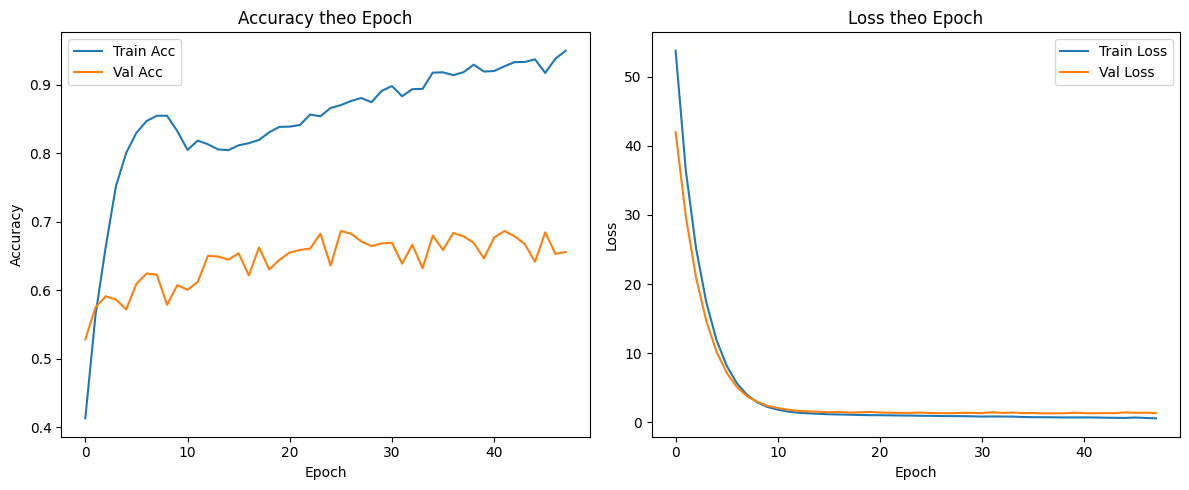

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


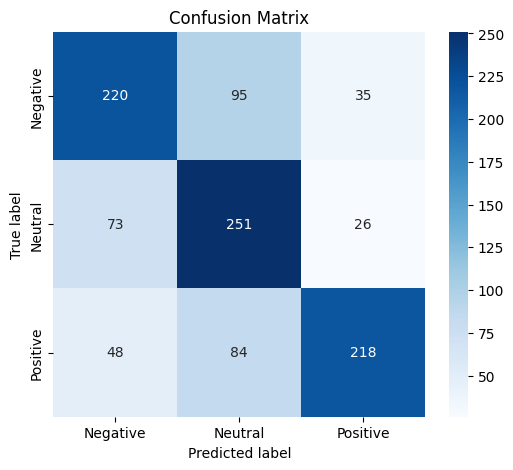


Classification Report:

              precision    recall  f1-score   support

    Negative       0.65      0.63      0.64       350
     Neutral       0.58      0.72      0.64       350
    Positive       0.78      0.62      0.69       350

    accuracy                           0.66      1050
   macro avg       0.67      0.66      0.66      1050
weighted avg       0.67      0.66      0.66      1050



In [22]:
# ==== CHẠY ====
pretrained_path = "/kaggle/input/vlsp-sentiment/datasets/vi-model-CBOW.bin"
train_and_evaluate(pretrained_path)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_x (InputLayer)      │ (None, 300)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 300, 400)       │      4,000,000 │ input_x[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 300, 400, 1)    │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 298, 1, 150)    │        180,150 │ reshape_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 297, 1, 150)    │        240,150 │ reshape_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 296, 1, 150)    │        300,150 │ reshape_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 1, 1, 150)      │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 1, 1, 150)      │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 1, 1, 150)      │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 1, 1, 450)      │              0 │ max_pooling2d_12[0][0… │
│ (Concatenate)             │                        │                │ max_pooling2d_13[0][0… │
│                           │                        │                │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_9 (Reshape)       │ (None, 450)            │              0 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 450)            │              0 │ reshape_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 3)              │          1,353 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,721,803 (18.01 MB)

 Trainable params: 4,721,803 (18.01 MB)

 Non-trainable params: 0 (0.00 B)

None


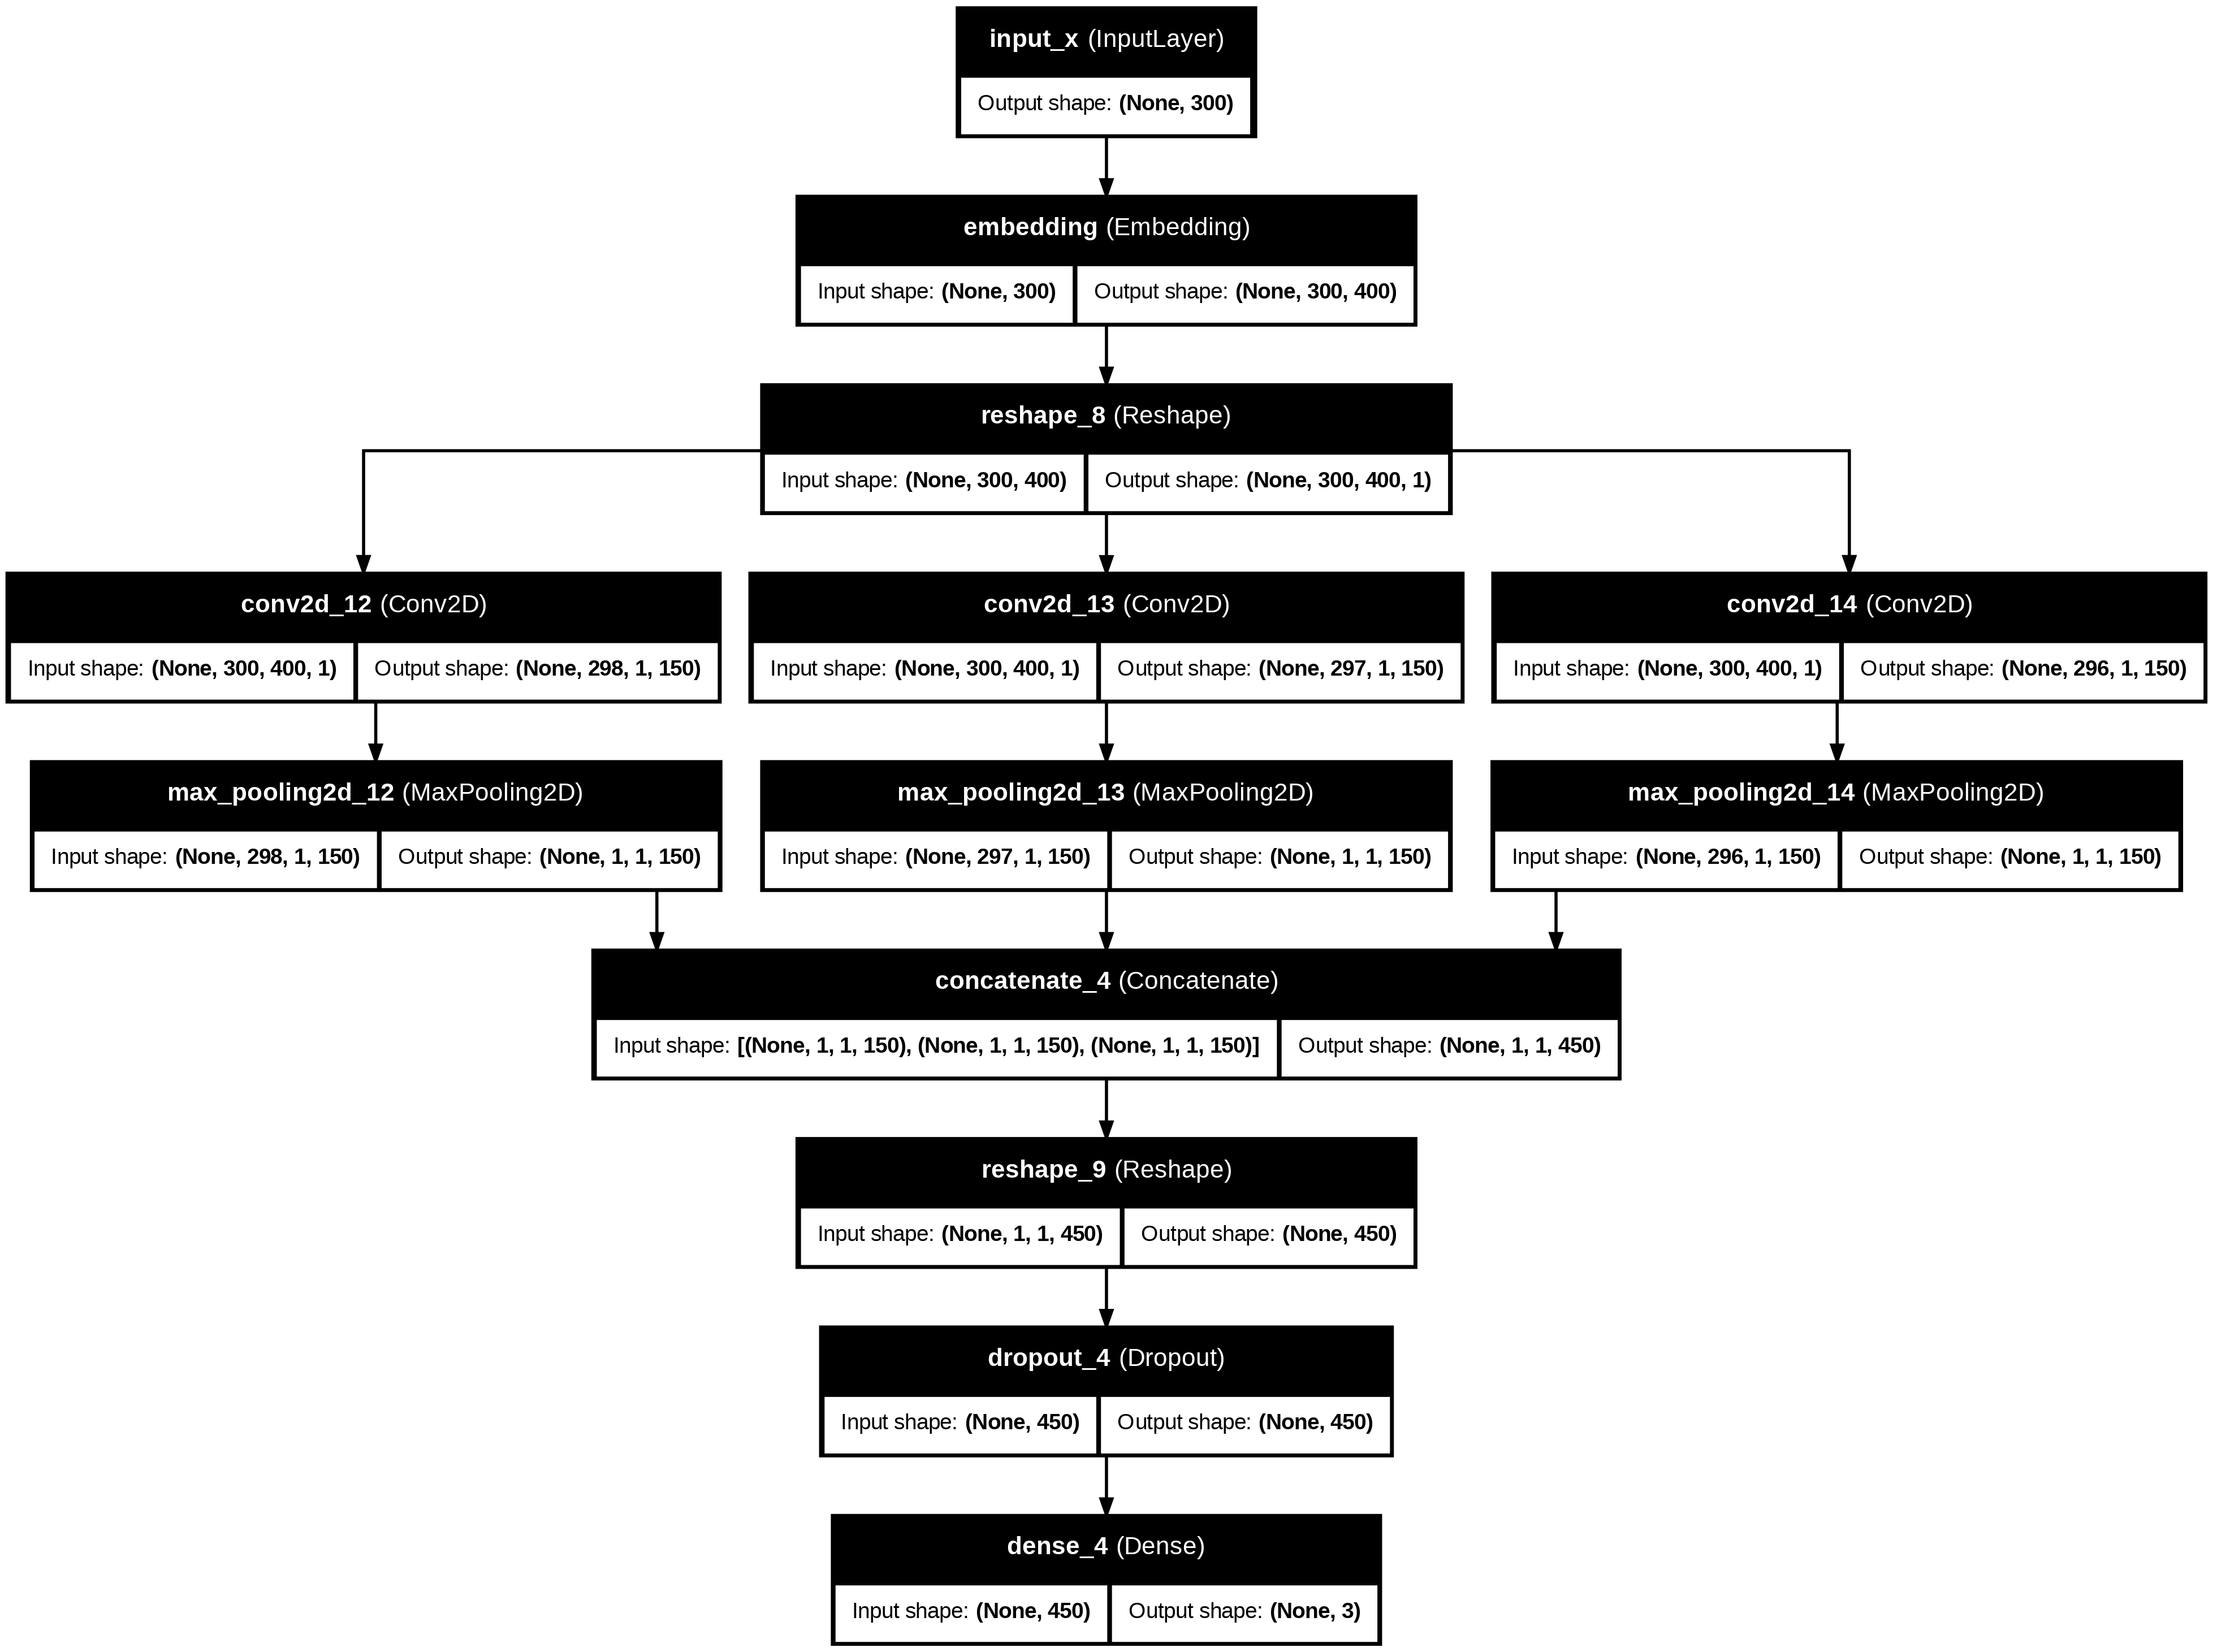

In [26]:
# Tạo embedding giả (nếu chưa có)
dummy_embedding_matrix = None
dummy_vocab_size = MAX_FEATURES  # hoặc số thực tế từ word_index

# Gọi lại build_model
model = build_model(dummy_embedding_matrix, dummy_vocab_size)

# Vẽ kiến trúc mô hình
from keras.utils import plot_model
plot_model(model, to_file='text_cnn_model.png', show_shapes=True, show_layer_names=True)
